<h1>Loan or No Loan Clssification using Random Forest

<h1>Import Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, make_scorer

import joblib
import json

<h1>Load the data

In [2]:
loan_data  = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Datasets/master/Loan_Data/loan_train.csv" , index_col=0)
loan_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP002305,Female,No,0,Graduate,No,4547,0.0,115.0,360.0,1.0,Semiurban,1
1,LP001715,Male,Yes,3+,Not Graduate,Yes,5703,0.0,130.0,360.0,1.0,Rural,1
2,LP002086,Female,Yes,0,Graduate,No,4333,2451.0,110.0,360.0,1.0,Urban,0
3,LP001136,Male,Yes,0,Not Graduate,Yes,4695,0.0,96.0,NaN,1.0,Urban,1
4,LP002529,Male,Yes,2,Graduate,No,6700,1750.0,230.0,300.0,1.0,Semiurban,1


<h1>Exploratory Data Analysis

In [3]:
loan_data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status
count,491.000000,491.000000,475.000000,478.000000,448.000000,491.000000
mean,5401.189409,1589.730998,145.014737,341.297071,0.848214,0.698574
std,6419.427177,2919.320624,86.310534,66.964051,0.359214,0.459345
min,150.000000,0.000000,17.000000,12.000000,0.000000,0.000000
25%,2923.500000,0.000000,100.000000,360.000000,1.000000,0.000000
50%,3865.000000,1229.000000,126.000000,360.000000,1.000000,1.000000
75%,5705.500000,2251.500000,162.000000,360.000000,1.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.000000,1.000000,1.000000


<h2>Checking attribute type

In [4]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 491 entries, 0 to 490
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            491 non-null    object 
 1   Gender             481 non-null    object 
 2   Married            490 non-null    object 
 3   Dependents         482 non-null    object 
 4   Education          491 non-null    object 
 5   Self_Employed      462 non-null    object 
 6   ApplicantIncome    491 non-null    int64  
 7   CoapplicantIncome  491 non-null    float64
 8   LoanAmount         475 non-null    float64
 9   Loan_Amount_Term   478 non-null    float64
 10  Credit_History     448 non-null    float64
 11  Property_Area      491 non-null    object 
 12  Loan_Status        491 non-null    int64  
dtypes: float64(4), int64(2), object(7)
memory usage: 53.7+ KB


<h2>Checking missing value

In [5]:
loan_data.isna().sum()
#there are some missing value in attribute gender, married, dependents, self_employed, loanAmount, 
#Loan_Amount_Term, and Credit_History

Loan_ID               0
Gender               10
Married               1
Dependents            9
Education             0
Self_Employed        29
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           16
Loan_Amount_Term     13
Credit_History       43
Property_Area         0
Loan_Status           0
dtype: int64

<h2>Checking outliers</h2>
on numerical attribute

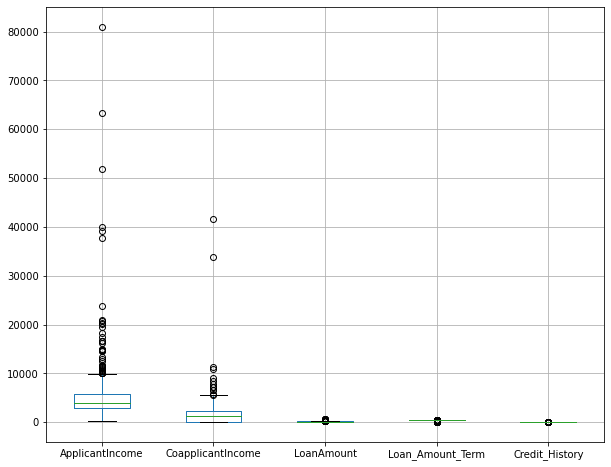

In [6]:
fig, ax = plt.subplots(figsize=(10,8))
loan_data[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount','Loan_Amount_Term', 'Credit_History']].boxplot()
plt.show()

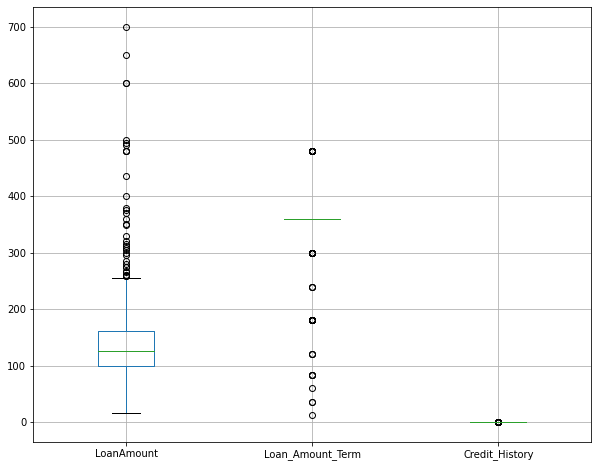

In [7]:
fig, ax = plt.subplots(figsize=(10,8))
loan_data[['LoanAmount','Loan_Amount_Term', 'Credit_History']].boxplot()
plt.show()

There are so many outliers, but i will use Random Forest Classifier that robust on outliers

<h2>Check Correlation between numerical attribute

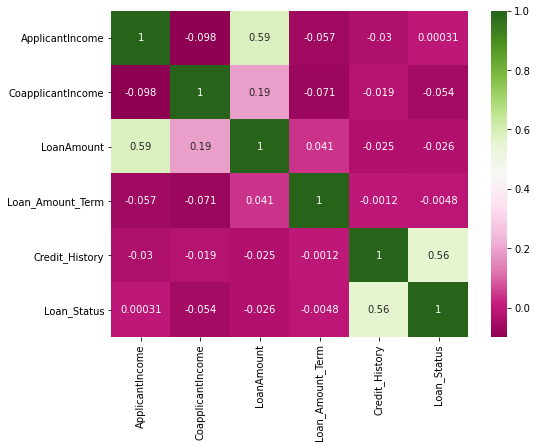

In [8]:
corrmat=loan_data.corr(method='pearson')
plt.figure(figsize=(8, 6))
sns.heatmap(corrmat, annot=True, cmap='PiYG')
plt.show()

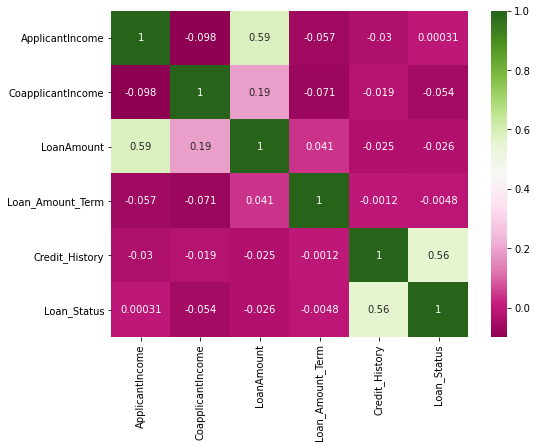

In [9]:
corrmat=loan_data.corr(method='pearson')
plt.figure(figsize=(8, 6))
sns.heatmap(corrmat, annot=True, cmap='PiYG')
plt.show()

There is no attributes that have high correlation with other attributes

<h2>Check class imbalance

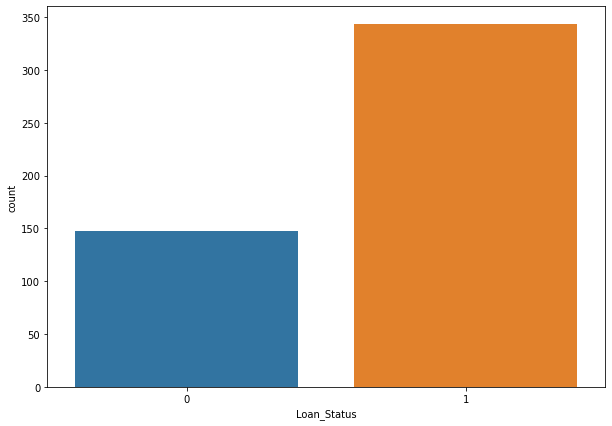

In [10]:
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(loan_data['Loan_Status'])
plt.show()
#i think target class is not balance because the number of 0 is half of the number of 1

<h1>Preprocessing

<h2>Replace category with number

In [11]:
loan_data['Property_Area'].unique()

array(['Semiurban', 'Rural', 'Urban'], dtype=object)

In [12]:
gender = {'Male':0, 'Female':1}
yes_no = {'No':0, 'Yes':1}
education = {'Not Graduate':0, 'Graduate':1}
area= {'Rural':0, 'Semiurban':1, 'Urban':2}

In [13]:
def dependents(data):
    try:
        float(data)
    except:
        return 3
    return float(data)

In [14]:
loan_data['Gender'] = loan_data['Gender'].map(gender)
loan_data['Married'] = loan_data['Married'].map(yes_no)
loan_data['Education'] = loan_data['Education'].map(education)
loan_data['Self_Employed'] = loan_data['Self_Employed'].map(yes_no)
loan_data['Property_Area'] = loan_data['Property_Area'].map(area)
loan_data['Dependents'] = loan_data['Dependents'].apply(dependents)

<h2>Fill missing value </h2>
with knnimputer

In [15]:
imputer = KNNImputer()

In [16]:
loan_data.iloc[:,1:] = pd.DataFrame(imputer.fit_transform(loan_data.iloc[:,1:]), columns=loan_data.columns[1:])

In [17]:
loan_data.isna().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

<h2>Split data

In [18]:
X_train, X_test, y_train, y_test = train_test_split(loan_data.iloc[:,1:-1], loan_data.iloc[:,-1], test_size=0.2, random_state=42, stratify=loan_data.iloc[:,-1])

<h2>Apply oversampling on training data

In [19]:
over = SMOTE()
X_train, y_train = over.fit_resample(X_train, y_train)

<h1>Build Model using Random Forest

In [20]:
rf = RandomForestClassifier()
param_grid = {'criterion':['gini','entropy'], 'n_estimators':np.arange(1,150), 'max_features':['auto', 'sqrt', 'log2']}
rs = RandomizedSearchCV(rf ,param_grid, scoring='f1_micro', cv=15)
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=15, estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120,

In [21]:
rs.best_score_

0.8297297297297297

In [22]:
rs.best_params_

{'n_estimators': 89, 'max_features': 'sqrt', 'criterion': 'entropy'}

<h1>Test and Evaluate the model

In [23]:
y_pred = rs.predict(X_test)
f1_score(y_test, y_pred)

0.8489208633093526

<h1>Create model file

In [24]:
filename = 'loan_no loan_rf_model.pkl'
joblib.dump(rs, filename)

['loan_no loan_rf_model.pkl']

<h1>Save Column Name

In [25]:
columns = {
    'data_columns':[col.lower() for col in X_train.columns]
}
with open("columns.json", "w") as f:
    f.write(json.dumps(columns))

<h1>Create y for Submission

In [26]:
test_data = pd.read_csv('https://raw.githubusercontent.com/dphi-official/Datasets/master/Loan_Data/loan_test.csv')

In [27]:
test_data['Gender'] = test_data['Gender'].map(gender)
test_data['Married'] = test_data['Married'].map(yes_no)
test_data['Education'] = test_data['Education'].map(education)
test_data['Self_Employed'] = test_data['Self_Employed'].map(yes_no)
test_data['Property_Area'] = test_data['Property_Area'].map(area)
test_data['Dependents'] = test_data['Dependents'].apply(dependents)

In [28]:
test_data.iloc[:,1:] = pd.DataFrame(imputer.fit_transform(test_data.iloc[:,1:]), columns=test_data.columns[1:])

In [29]:
y_submission = pd.DataFrame(rs.predict(test_data.iloc[:,1:]), columns=['prediction'])

In [30]:
y_submission['prediction'] = y_submission['prediction'].astype('int')

In [31]:
y_submission.to_csv('submission.csv', index=False)